# Machine Learning in the Real World

##                1.Data preparation and cleaning

## Import Python Libraries

In [32]:
%matplotlib inline

import pandas as pd
import numpy as np
#import seaborn as sns
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pathlib
import csv
import math
import matplotlib.pyplot as plt

## Defining Data Paths And Variables

In [33]:
# Data paths
path_train = 'working_data/train_data.csv'
path_test = 'working_data/test_data.csv'
path_complete_data = 'merged_data_ready/merged_data.csv'
paths = []
paths.append('raw_data\DB_Data\Jobs.csv')
paths.append('raw_data\DB_Data\Global_Financial_Development_Data_2.csv')
paths_fixed = []
paths_fixed.append('raw_data\DB_Data\Job_fixed.csv')
paths_fixed.append('raw_data\DB_Data\Global_Financial_Development_Data_2_fixed.csv')
input_labels = 'raw_data\Labels\Happy_Planet_Index_Data'

# Paths for the graphical map visualization use
countries_codes = 'raw_data\DB_Data\WDI_Country.csv'
shapefile = 'map_files/ne_10m_admin_0_countries'
template_image = 'map_files/imgfile.png'
globe_plots = 'globe_plots/'
uncorrolated_plots = 'uncorrolated_images/'

# Years with labels
rellevant_years_for_labels = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',\
                              '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2009', '2012', '2016']
rellevant_years = [year + '.00' for year in rellevant_years_for_labels]

## Functions For Obtaining Data




### Merge the data with the labels

In [71]:
def mergeDataWithLabels(working_frame, labels):
    result = pd.merge(working_frame, labels, how='inner', on=['country', 'year'])
    msk = np.random.rand(len(result)) < 0.8
    train = result[msk]
    train.reset_index(drop=True, inplace=True)
    test = result[~msk]
    test.reset_index(drop=True, inplace=True)
    train.to_csv(path_train)
    test.to_csv(path_test)
    result.to_csv(path_complete_data)
    return result.columns

### Cleaning the CSV Files Out From Commas

In [72]:
def cleanCommasFromCSV(path_old, path_new):
    with open(path_old, "r", newline="") as infile, open(path_new, "w", newline="") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for row in reader:
            writer.writerow(item.replace(",", "") for item in row)

### Obtain The Labeled Data

In [73]:
def getDataFrameForLabelCSV(path, year):
    df = pd.read_csv(path, skiprows=0, usecols=[1, 8])
    df.loc[:, 'year'] = pd.Series(float(rellevant_years[rellevant_years_for_labels.index(year)]), index=df.index)
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    df.drop(df.index[[0]])
    return df

### Take Data From DataSets

In [74]:
def extractDataFromCSV(paths, path_downloaded):
    l = []
    for path in paths:
        # first, drop irrelevant years
        df = pd.read_csv(path, header=None, skiprows=0, encoding='iso-8859-1', low_memory=False)
        df.loc[0, 0] = 'country'
        df.columns = df.loc[0]
        column_years = df.columns[2:]
        years_to_drop = [y for y in column_years if y not in rellevant_years]
        df.drop(years_to_drop, axis=1, inplace=True)

        # re-pivot the data and reindex
        df = pd.pivot_table(df, index='country', columns='Series Name', aggfunc=lambda x: ' '.join(x))
        df = df.stack(level=0)
        df.reset_index(inplace=True)
        df.rename(columns={0: 'year'}, inplace=True)
        df.rename(columns={"Series Name": 'series'}, inplace=True)
        df.to_csv(path_downloaded)
        df = pd.read_csv(path_downloaded, encoding='iso-8859-1', low_memory=False)
        df.drop(df.columns[[0]], axis=1, inplace=True)
        l.append(df)
    data_df = l[0]
    for i in range(1,len(l)):
        data_df = data_df.merge(l[i], how='outer')
    data_df.replace('..', np.nan, inplace=True)
    data_df = data_df.dropna(axis=1, how='all')
    data_df = data_df[data_df.country != 'country']
    data_df = data_df.T.drop_duplicates().T
    #data_df.to_csv(path_downloaded)
    return data_df

### The Main Data Extract Function

In [75]:
def obtainDataFromLocalDBs():
    # extract the labels dataframe from the csv files
    lis = []
    for year in rellevant_years_for_labels:
        path = input_labels + '_' + year + '.csv'
        path = pathlib.Path(path)
        df = getDataFrameForLabelCSV(path, year)
        lis.append(df)
    labels_df = pd.concat(lis)

    # extract all the data dataframe from the csv files
    for i in range(len(paths)):
        cleanCommasFromCSV(paths[i], paths_fixed[i])
    df = extractDataFromCSV(paths_fixed, path_complete_data)

    # merge (by inner join) the data with the labels
    mergeDataWithLabels(df, labels_df)

### Run to Extract Data (run is needed just once)

In [76]:
obtainDataFromLocalDBs()

## Graphical representation on globus map

### For viewing map graphics, you should install 2 libraries:

#### 1. Install Basemap:
        · To install this package with conda run, type:
          conda install -c conda-forge basemap=1.0.8.dev0
        · download package and install from: http://matplotlib.org/basemap/
#### 2. Install GeonamesCache:
        · To install this package with conda run, type:
          conda install -c mbonix geonamescache=0.20
        · download package and install from: https://pypi.python.org/pypi/geonamescache
          look for version 0.20

In [97]:
import matplotlib.cm
import matplotlib as mpl
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

def plotDataOnMap(data, year = 'mean', feature = "Happy Planet Index"):    
    num_colors = 9
    cols = ['country', feature]
    splitted = feature.split()
    title = feature + ' rate per country'
    imgfile = globe_plots + feature + '_'+ year + '.png'

    descripton = '''
    Expected values of the {} rate of countriers. Countries without data are shown in grey.
    Data: World Bank - worldbank.org • Lables: HappyPlanetIndex - happyplanetindex.org'''.format(feature)

    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())
    df = pd.read_csv(countries_codes, skiprows=0, usecols=[0, 1], encoding='iso-8859-1')
    data_map = pd.merge(df, train_data, how='inner', on=['country'])
    if year == 'mean':
        data_map = data_map[['Country Code', 'country', feature]]
        data_map = data_map.groupby(['Country Code'], sort=False).mean()
    else:
        data_map = data_map[['Country Code', 'year', 'country', feature]]
        data_map = data_map.loc[data_map['year'] == float(year)]
        data_map = data_map[['Country Code', 'country', feature]]
        data_map = data_map.groupby(['Country Code'], sort=False).first()
    data_map.reset_index(inplace=True)
    values = data_map[feature]
    data_map.set_index('Country Code', inplace=True)
    cm = plt.get_cmap('Greens')
    scheme = [cm(i / num_colors) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    data_map['bin'] = np.digitize(values, bins) - 1
    data_map.sort_values('bin', ascending=False).head(10)
    fig = plt.figure(figsize=(22, 12))

    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    if year == 'mean':
        fig.suptitle('mean {} rate for all data'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
    else:
        fig.suptitle('{} rate in year {}'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')

    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in data_map.index:
            color = '#dddddd'
        else:
            ind = data_map.ix[iso3, 'bin'].astype(np.int64)
            color = scheme[ind]

        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
    cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

    # Set the map footer.
    plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')

    plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
    plt.plot()

## Images comparison method

### For images map comparison, you should install opencv library
        · To install this package with conda run, type:
          conda install -c conda-forge basemap=1.0.8.dev0
        · download package and install from: http://matplotlib.org/basemap/

In [109]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

def plotUncorrolatedCountries(im1, im2, output):
    img1 = cv2.imread(im1, 1)
    img2 = cv2.imread(im2, 1)
    null_img = cv2.imread(template_image, 1)
    
    img1 = cv2.cvtColor( img1, cv2.COLOR_BGR2GRAY  )
    img2 = cv2.cvtColor( img2, cv2.COLOR_BGR2GRAY  )
    null_img = cv2.cvtColor( null_img, cv2.COLOR_BGR2GRAY  )
    
    height1, width1 = img1.shape
    height2, width2 = img2.shape
    height3, width3 = null_img.shape
    
    min_h = min(height1, height2, height3)
    min_w = min(width1, width2, width3)
    
    img1 = img1[:min_h, :min_w]
    img2 = img2[:min_h, :min_w]
    null_img = null_img[:min_h, :min_w]

    crop_img = cv2.subtract(img1, img2)[65:900, :]

    null_img = null_img[65:900, :]
    thresh = (255-crop_img)
    
    cv2.addWeighted(thresh, 0.5, null_img, 0.5, 0, thresh)
    (threshold, thresh) = cv2.threshold(thresh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    flag = cv2.imwrite(output, thresh)
    plt.axis('off')
    plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic'),plt.show()


## Reading the Working Datasets

In [36]:
train_data = pd.read_csv(path_train, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
test_data = pd.read_csv(path_test, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
train_data.head(10)

,country,year,Access to electricity (% of population),Adolescent fertility rate (births per 1000 women ages 15-19),Age dependency ratio (% of working-age population),Agriculture value added (% of GDP),Agriculture value added (annual % growth),Agriculture value added (constant 2005 US$),Agriculture value added per worker (constant 2005 US$),Air transport registered carrier departures worldwide,...,Stock market total value traded to GDP (%),Stock market turnover ratio (%),Stock price volatility,Syndicated loan average maturity (years),Syndicated loan issuance volume to GDP (%),Total factoring volume to GDP (%),Value of collateral needed for a loan (% of the loan amount),Value traded excluding top 10 traded companies to total value traded (%),Working capital financed by banks (%),Happy Planet Index
0,Afghanistan,2012.0,43.0,87.79,95.31,24.60,18.22,2.645462e+09,413.03,17775.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8
1,Albania,2006.0,NaN,18.73,52.15,22.00,3.10,1.693547e+09,2696.73,4481.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.1
2,Albania,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.1
3,Albania,2009.0,NaN,19.48,48.64,19.41,1.90,1.897705e+09,3065.76,5140.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.9
4,Albania,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.1
5,Albania,2016.0,100.0,21.49,44.91,22.67,1.98,2.317571e+09,3914.82,1994.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8
6,Algeria,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.91,0.83,NaN,NaN,NaN,NaN,45.9
7,Algeria,2009.0,NaN,10.38,48.65,9.53,21.10,1.024569e+10,3245.39,52731.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.2
8,Algeria,2009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.2
9,Algeria,2012.0,100.0,11.43,49.85,9.30,NaN,NaN,NaN,54292.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.2


## Find Most Corrolated features

In [73]:
THRESHOLD = 0.4
train_data_corr_mat= train_data.corr(method='spearman')
HPI_correlation = pd.DataFrame(train_data_corr_mat[train_data_corr_mat.columns[len(train_data_corr_mat.columns)-1]])
HPI_correlation.head(5)
HPI_pos_correlation = HPI_correlation[HPI_correlation[HPI_correlation.columns[len(HPI_correlation.columns)-1]] > \
                                      THRESHOLD]
HPI_neg_correlation = HPI_correlation[HPI_correlation[HPI_correlation.columns[len(HPI_correlation.columns)-1]] < \
                                      (THRESHOLD*(-1))]
HPI_relevant_correlation = HPI_pos_correlation.append(HPI_neg_correlation)
columns_new = ['Feature', 'Feature-Target Corrolation']
HPI_relevant_correlation.to_csv("Rcorr2_0.csv", sep=',', encoding='utf-8')
print(HPI_relevant_correlation)

                                                    Happy Planet Index
Daily newspapers (per 1000 people)                            0.495820
Bank accounts per 1000 adults                                 0.428593
Firms using banks to finance working capital (%)              0.454451
Firms with a bank loan or line of credit (%)                  0.473912
Investments financed by banks (%)                             0.413601
Small firms with a bank loan or line of credit (%)            0.448373
Working capital financed by banks (%)                         0.469035
Happy Planet Index                                            1.000000
Prevalence of HIV total (% of population ages 1...           -0.424831
Firms identifying access to finance as a major ...           -0.549484


## Plotting the Happy Planet Index over the globe

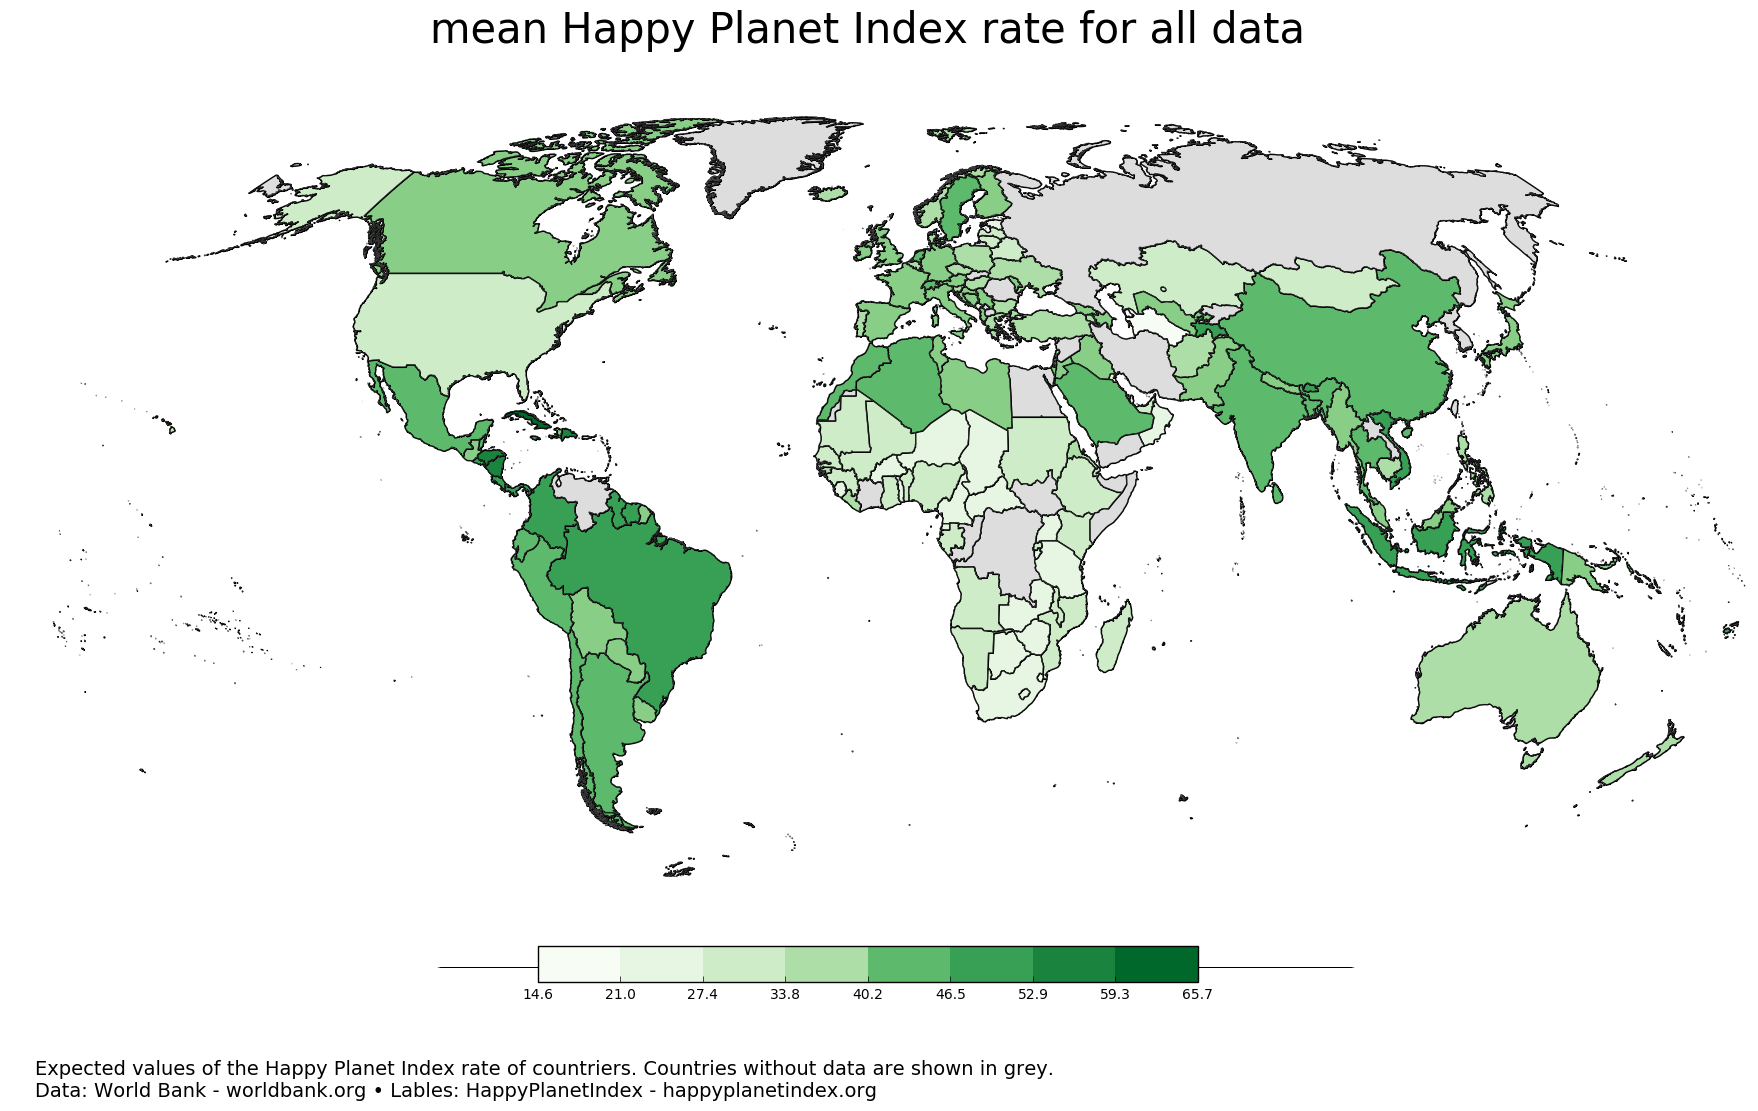

In [76]:
plotDataOnMap(train_data, feature='Happy Planet Index', year='mean')

## Plotting the Daily newspapers (per 1000 people) over the globe

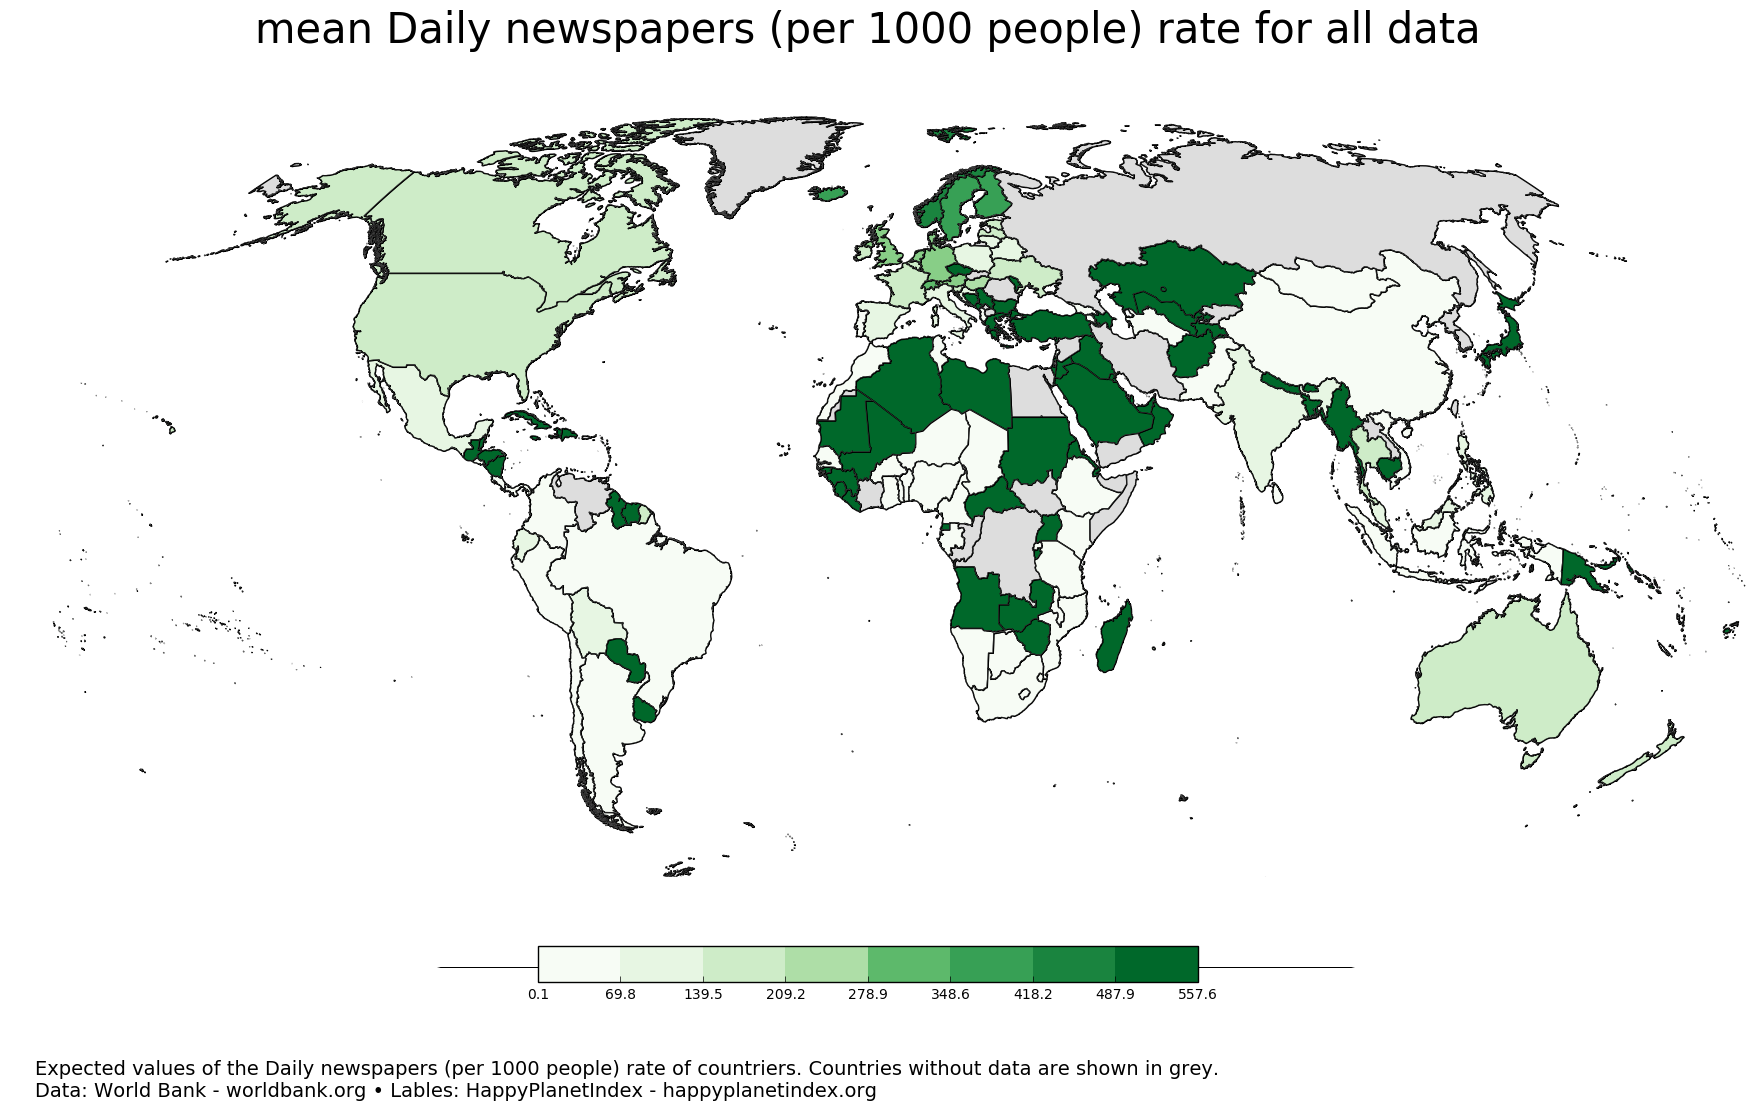

In [94]:
plotDataOnMap(train_data, feature='Daily newspapers (per 1000 people)', year='mean')

### Which Countries doesn't corrolate in Daily newspapers feature and target

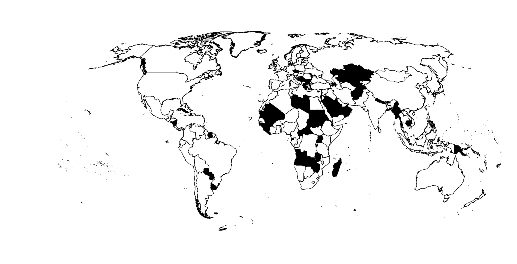

In [105]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + 'Daily newspapers (per 1000 people)_mean.png'
output_image = uncorrolated_plots + 'Daily_newspapers.png'
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the Bank accounts per 1000 adults over the globe

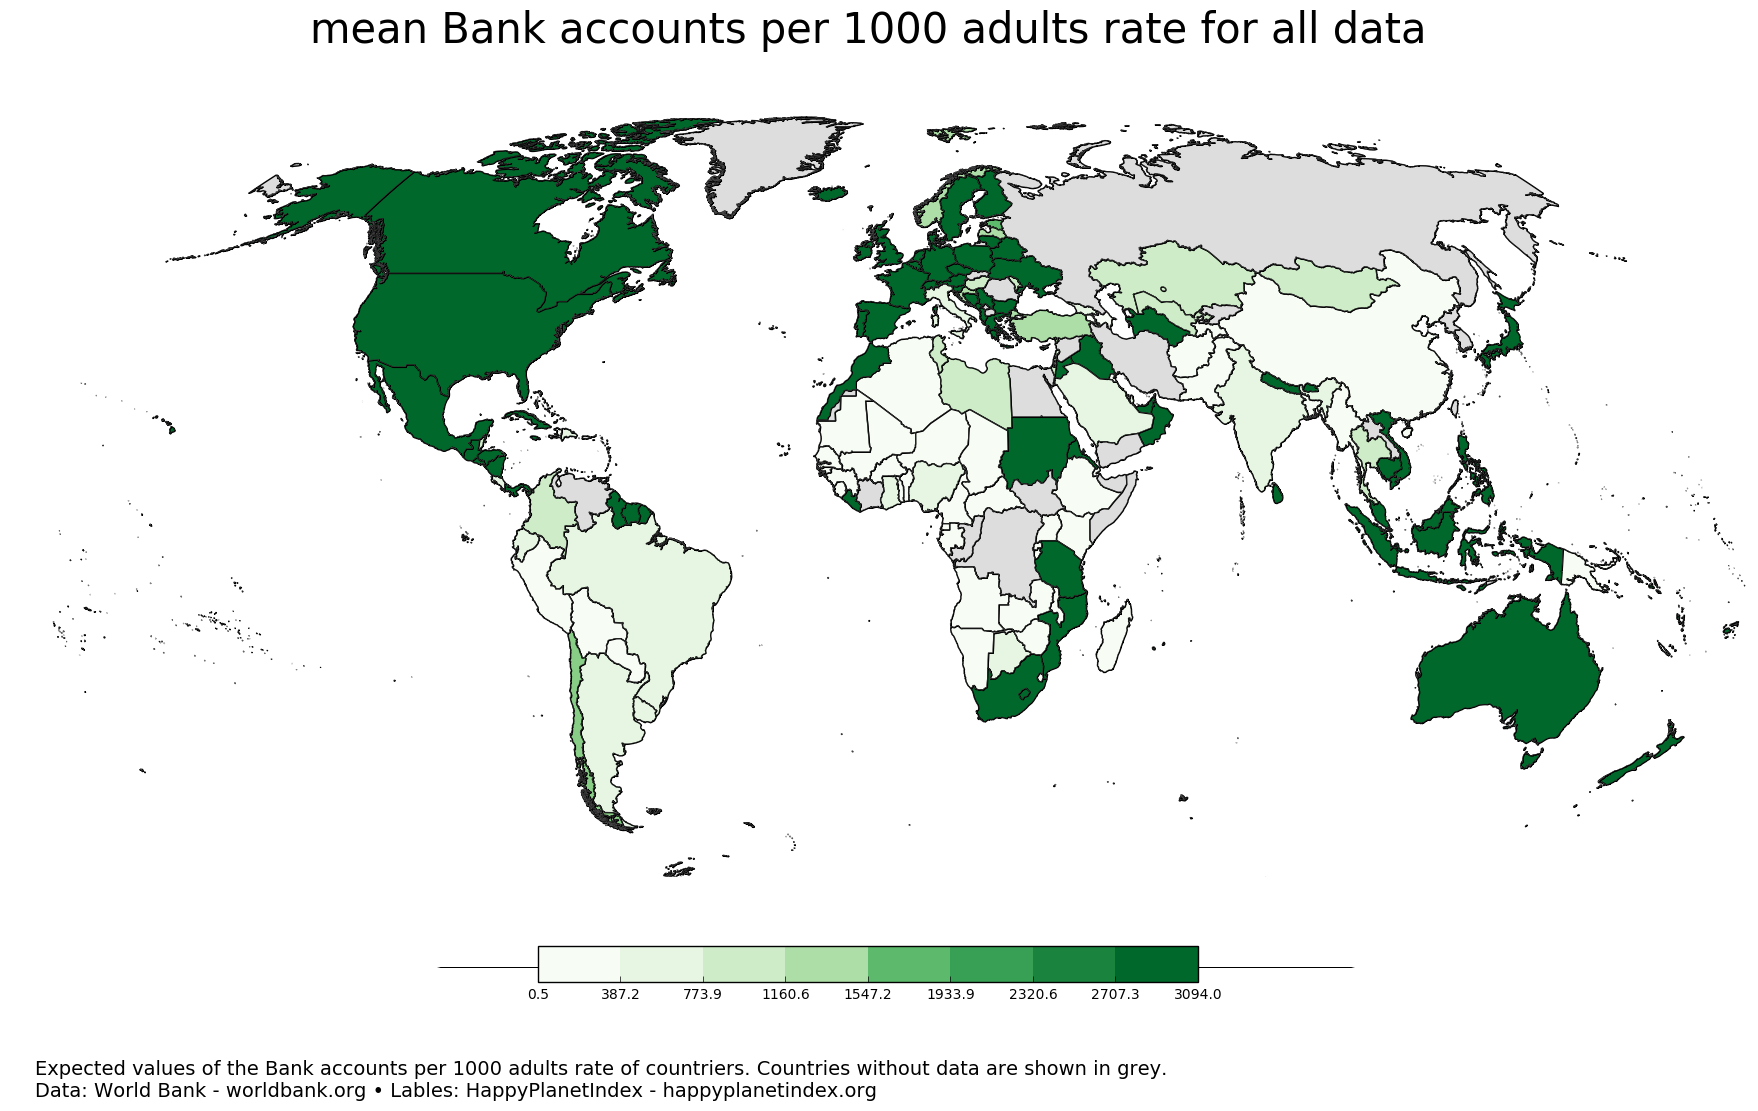

In [82]:
plotDataOnMap(train_data, feature='Bank accounts per 1000 adults', year='mean')

### Which Countries doesn't corrolate in Bank accounts feature and target

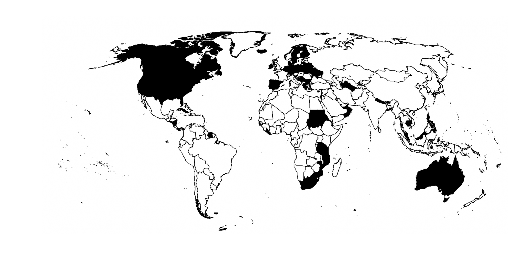

In [106]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + 'Bank accounts per 1000 adults_mean.png'
output_image = uncorrolated_plots + 'Bank_accounts.png'
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the Firms identifying access to finance as a major constraint (%) over the globe

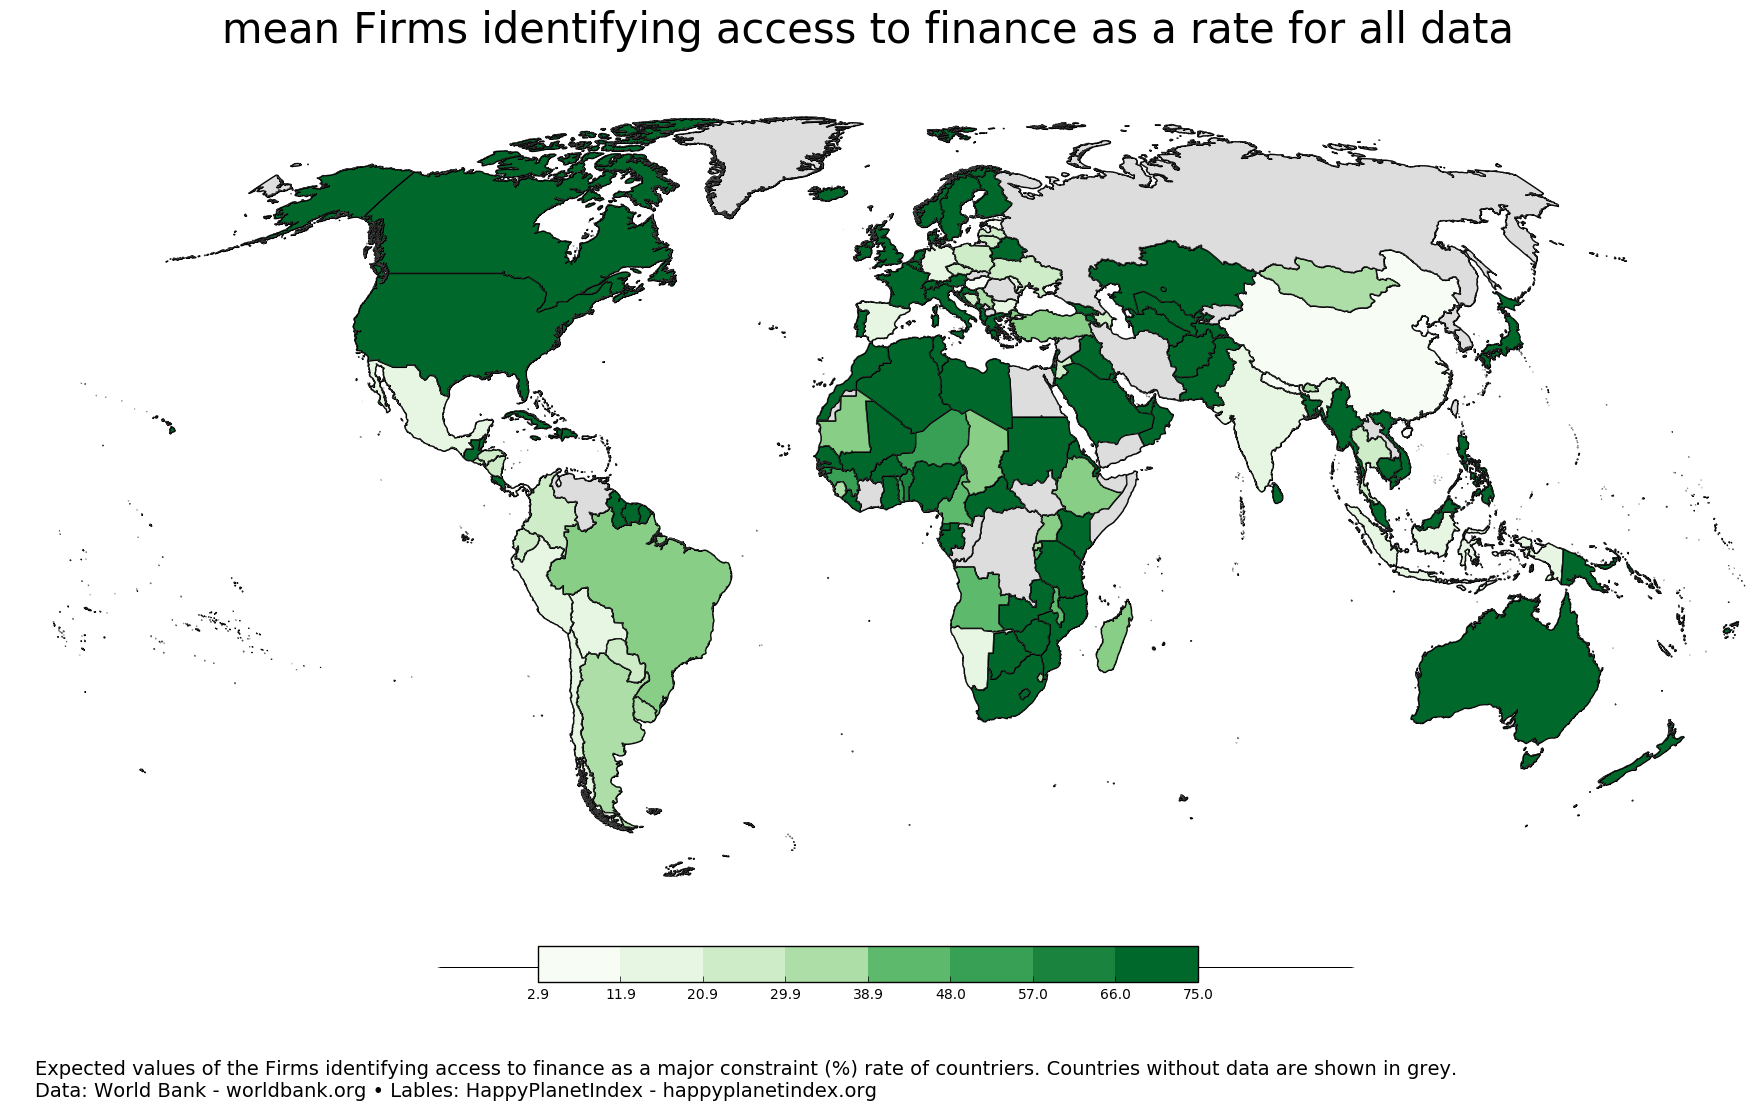

In [98]:
plotDataOnMap(train_data, feature='Firms identifying access to finance as a major constraint (%)', year='mean')

### Which Countries doesn't corrolate in Firms identifying access to finance feature and target

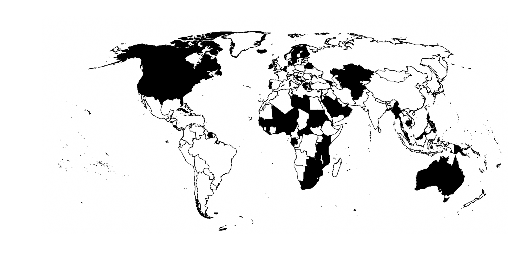

In [111]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + 'Firms identifying access to finance as a major constraint (%)_mean.png'
output_image = uncorrolated_plots + 'Firms_identifying_access_to_finance.png'
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Features dict

In [28]:
train_data.head(1).to_dict()

{'5-bank asset concentration': {0: 85.340000000000003},
 'ATMs per 100000 adults': {0: 0.67000000000000004},
 'Access to electricity (% of population)': {0: 43.0},
 'Adolescent fertility rate (births per 1000 women ages 15-19)': {0: 87.790000000000006},
 'Age dependency ratio (% of working-age population)': {0: 95.310000000000002},
 'Agriculture value added (% of GDP)': {0: 24.600000000000001},
 'Agriculture value added (annual % growth)': {0: 18.219999999999999},
 'Agriculture value added (constant 2005 US$)': {0: 2645461729.0},
 'Agriculture value added per worker (constant 2005 US$)': {0: 413.02999999999997},
 'Air transport registered carrier departures worldwide': {0: 17775.0},
 'Bank Z-score': {0: 7.04},
 'Bank accounts per 1000 adults': {0: 174.63},
 'Bank branches per 100000 adults': {0: 2.2400000000000002},
 'Bank capital to total assets (%)': {0: nan},
 'Bank concentration (%)': {0: 64.209999999999994},
 'Bank cost to income ratio (%)': {0: 57.5},
 'Bank credit to bank deposi

## Drop  columns with #nulls>threshold


In [101]:
nulls_stat=np.sum(train_data.isnull())/(train_data.shape[0])*100
problem_cols=train_data.columns[nulls_stat>30]

# Drop problematic columns
n_calls_old=train_data.shape[1]
for col in problem_cols:
    train_data=train_data.drop(col, 1)
    test_data=test_data.drop(col, 1)

## One Hot Encoding Foreach Country

In [102]:
#train
oh_train_data=train_data.drop('country',axis=1)
onehot_train_col = pd.get_dummies(train_data['country'], prefix='country')
oh_train_data = pd.concat([oh_train_data, onehot_train_col], axis=1)
train_data=oh_train_data
#test
oh_test_data=test_data.drop('country',axis=1)
onehot_test_col = pd.get_dummies(test_data['country'], prefix='country')

#check for missing cols in onehot_test_col
for col in onehot_train_col.columns:
    if col not in onehot_test_col.columns:
        oh_test_data[col]=0
        
oh_test_data = pd.concat([oh_test_data, onehot_test_col], axis=1)
test_data=oh_test_data

### Change all values' datatypes to float

In [103]:
for variable in train_data.columns:
    train_data[variable] = train_data[variable].astype(np.float)
for variable in test_data.columns:
    test_data[variable] = test_data[variable].astype(np.float)

### Impute nulls with medians

In [105]:
train_data = train_data.fillna(train_data.median())
test_data = test_data.fillna(test_data.median())
train_data.head(5)

,year,Adolescent fertility rate (births per 1000 women ages 15-19),Age dependency ratio (% of working-age population),Agriculture value added (% of GDP),Air transport registered carrier departures worldwide,Consumer price index (2010 = 100),Domestic credit provided by financial sector (% of GDP),Domestic credit to private sector (% of GDP),Exports of goods and services (% of GDP),Exports of goods and services (annual % growth),...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,2012.0,87.79,95.31,24.60,17775.00,118.16,-4.03,4.05,5.52,4.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2006.0,18.73,52.15,22.00,4481.00,88.75,54.51,21.83,25.09,4.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006.0,20.59,51.29,4.78,95211.68,89.01,75.32,22.17,33.50,4.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2009.0,19.48,48.64,19.41,5140.00,96.57,68.38,36.92,29.60,4.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012.0,20.59,51.29,4.78,95211.68,89.01,75.32,39.06,33.50,4.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Partition to factors and class

In [106]:
train_class = train_data['Happy Planet Index']
train_factors =(train_data.drop('Happy Planet Index', axis=1))

test_class = test_data['Happy Planet Index']
test_factors =(test_data.drop('Happy Planet Index', axis=1))

## Binning The Years by Decades

In [107]:
#binning the years train
min_year=min(min(train_factors['year']),min(test_factors['year']))

def decade(year):
    return(math.floor((year-min_year) /10))

for row in range(train_factors.shape[0]):
    val=train_factors.at[row, 'year']
    new_val=decade(val)
    train_factors.set_value(row, 'year', new_val)
    
#binning the years test

for row in range(test_factors.shape[0]):
    val=test_factors.at[row, 'year']
    new_val=decade(val)
    test_factors.set_value(row, 'year', new_val)

## Centering and Scaling

In [ ]:
#train
for col in train_factors.columns:
    mean = train_factors[col].mean()
    std = train_factors[col].std()
    for row in range(train_factors.shape[0]):
        train_factors.set_value(row,col,(train_factors.at[row,col]-mean)/std)
class_mean=train_class.mean()
for row in range(train_factors.shape[0]):
    train_class.set_value(row, train_class[row]-class_mean)
#test
for col in test_factors.columns:
    mean = test_factors[col].mean()
    std = test_factors[col].std()
    for row in range(test_factors.shape[0]):
        test_factors.set_value(row,col,(test_factors.at[row,col]-mean)/std)
class_mean=test_class.mean()
for row in range(test_factors.shape[0]):
    test_class.set_value(row, test_class[row]-class_mean)

## Drop Unnecessary Column

In [14]:
train_data = train_data.drop(train_data.columns[:2], axis=1)
test_data = test_data.drop(test_data.columns[:2], axis=1)

In [35]:
train_data.head(10)

,Access to electricity (% of population),Adolescent fertility rate (births per 1000 women ages 15-19),Age dependency ratio (% of working-age population),Agriculture value added (% of GDP),Agriculture value added (annual % growth),Agriculture value added (constant 2005 US$),Agriculture value added per worker (constant 2005 US$),Air transport registered carrier departures worldwide,CPIA economic management cluster average (1=low to 6=high),CPIA financial sector rating (1=low to 6=high),...,Urban population,Urban population (% of total),Vehicles (per km of road),Vulnerable employment female (% of female employment),Vulnerable employment male (% of male employment),Wage and salaried workers female (% of females employed),Wage and salaried workers total (% of total employed),Wage and salary workers male (% of males employed),Weeks of severance pay for redundancy of experienced workers,Happy Planet Index
0,43.0,87.79,95.31,24.60,18.22,2.645462e+09,413.03,17775.00,3.00,2.0,...,7570822.0,25.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8
1,43.0,76.73,89.77,23.97,1.90,2.689738e+09,395.78,25389.38,3.00,2.0,...,8312341.0,26.28,41.58,NaN,NaN,NaN,NaN,NaN,26.0,20.2
2,NaN,18.73,52.15,22.00,3.10,1.693547e+09,2696.73,4481.00,4.00,4.0,...,1430886.0,47.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.1
3,NaN,19.48,48.64,19.41,1.90,1.897705e+09,3065.76,5140.00,NaN,NaN,...,1495260.0,51.08,NaN,NaN,NaN,34.0,41.4,47.1,NaN,47.9
4,100.0,20.80,45.84,21.83,5.41,2.256162e+09,3735.37,10309.18,NaN,NaN,...,1575836.0,54.33,NaN,68.9,58.0,30.1,35.7,40.1,NaN,54.1
5,NaN,9.69,50.40,7.75,8.10,8.580218e+09,2820.58,44822.00,NaN,NaN,...,21799703.0,64.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.9
6,NaN,10.38,48.65,9.53,21.10,1.024569e+10,3245.39,52731.00,NaN,NaN,...,23656184.0,66.82,34.41,NaN,NaN,39.2,33.1,32.0,NaN,51.2
7,100.0,11.43,49.85,9.30,NaN,NaN,NaN,54292.00,NaN,NaN,...,25784533.0,68.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.2
8,100.0,10.79,51.54,10.01,10.30,1.185475e+10,3718.55,59588.20,NaN,NaN,...,27304259.0,70.13,35.60,24.4,27.5,73.7,69.0,67.9,13.0,33.3
9,NaN,191.96,102.29,7.66,9.80,2.631959e+09,503.05,4965.00,2.67,2.5,...,6849589.0,36.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.9


## Specifying Data Types

In [36]:
binary_variables = ['class']
categorical_variables = ['workclass', 'education', 'education-num', 'marital-status', 
                         'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_variables = ['hours-per-week','age','capital-gain','capital-loss']

## Type Conversion

In [21]:
train_data[categorical_variables].dtypes

KeyError: "['workclass' 'education' 'education-num' 'marital-status' 'occupation'\n 'relationship' 'race' 'sex' 'native-country'] not in index"

In [12]:
train_data[numeric_variables].dtypes

hours-per-week    int64
age               int64
capital-gain      int64
capital-loss      int64
dtype: object

## Categorical and Binary Variables to String

In [13]:
for variable in categorical_variables + binary_variables:
    train_data[variable] = train_data[variable].astype(np.str)
    test_data[variable] = test_data[variable].astype(np.str)

## Numeric Variables to Float

In [14]:
for variable in numeric_variables:
    train_data[variable] = train_data[variable].astype(np.float)
    test_data[variable] = test_data[variable].astype(np.float)

In [15]:
train_data[numeric_variables].dtypes

hours-per-week    float64
age               float64
capital-gain      float64
capital-loss      float64
dtype: object

## Remove Whitespaces

In [16]:
# Map(func,sequence) -  operates a function on a sequence
# Lambda var1,var2.. : Expression -  Creates an inline function
for variable in categorical_variables + binary_variables:
    train_data[variable] = train_data[variable].map(lambda x : x.strip())
    test_data[variable] = test_data[variable].map(lambda x : x.strip())

## Binarize class label

In [17]:
train_data['class'] = train_data['class'].map(lambda x : '0' if x == '<=50K' else '1')
test_data['class'] = test_data['class'].map(lambda x : '0' if x == '<=50K' else '1')

In [18]:
test_data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,?,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,0


## Impute Missing Values

In [19]:
# missing values are appearing as '?'
# replace them with np.nan

for variable in train_data.columns:
    train_data[variable] = train_data[variable].replace('?', np.nan)

for variable in test_data.columns:
    test_data[variable] = test_data[variable].replace('?', np.nan)

In [93]:
np.sum(train_data.isnull())

Age dependency ratio (% of working-age population)                                                          1
Agriculture value added (% of GDP)                                                                         28
Agriculture value added (annual % growth)                                                                  32
Agriculture value added (constant 2005 US$)                                                                37
Agriculture value added per worker (constant 2005 US$)                                                     38
Air transport registered carrier departures worldwide                                                      62
CPIA economic management cluster average (1=low to 6=high)                                                325
CPIA financial sector rating (1=low to 6=high)                                                            325
CPIA gender equality rating (1=low to 6=high)                                                             325
CPIA macro

In [94]:
np.sum(test_data.isnull())

Age dependency ratio (% of working-age population)                                                          1
Agriculture value added (% of GDP)                                                                         10
Agriculture value added (annual % growth)                                                                   9
Agriculture value added (constant 2005 US$)                                                                11
Agriculture value added per worker (constant 2005 US$)                                                     12
Air transport registered carrier departures worldwide                                                      16
CPIA economic management cluster average (1=low to 6=high)                                                 81
CPIA financial sector rating (1=low to 6=high)                                                             81
CPIA gender equality rating (1=low to 6=high)                                                              81
CPIA macro

In [22]:
imputed_variables = ['workclass','occupation','native-country']
imputed_values = train_data[imputed_variables].mode()
print(imputed_values)

  workclass      occupation native-country
0   Private  Prof-specialty  United-States


In [23]:
for variable in imputed_variables:
    train_data[variable].fillna(value = imputed_values[variable][0], inplace=True)
    test_data[variable].fillna(value = imputed_values[variable][0], inplace=True)

In [24]:
train_data.head(10)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39.0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50.0,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38.0,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53.0,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28.0,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0
5,37.0,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,0
6,49.0,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,0
7,52.0,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,1
8,31.0,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,1
9,42.0,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,1


## Randomly Shuffle Training Data

In [96]:
train_data = train_data.sample(frac = 1)

## Data Statistics

In [97]:
train_data.describe()

C:\Users\Avi\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Age dependency ratio (% of working-age population),Agriculture value added (% of GDP),Agriculture value added (annual % growth),Agriculture value added (constant 2005 US$),Agriculture value added per worker (constant 2005 US$),Air transport registered carrier departures worldwide,CPIA economic management cluster average (1=low to 6=high),CPIA financial sector rating (1=low to 6=high),CPIA gender equality rating (1=low to 6=high),CPIA macroeconomic management rating (1=low to 6=high),...,Urban population,Urban population (% of total),Vehicles (per km of road),Vulnerable employment female (% of female employment),Vulnerable employment male (% of male employment),Wage and salaried workers female (% of females employed),Wage and salaried workers total (% of total employed),Wage and salary workers male (% of males employed),Weeks of severance pay for redundancy of experienced workers,Happy Planet Index
count,511.000000,484.00000,480.000000,4.750000e+02,474.000000,4.500000e+02,187.000000,187.000000,187.000000,187.000000,...,5.120000e+02,512.000000,248.000000,292.000000,292.000000,321.000000,329.000000,321.000000,99.000000,512.000000
mean,59.552387,12.87126,2.073479,1.512650e+10,12067.355169,2.508986e+05,3.624118,3.139037,3.486631,3.780749,...,2.943783e+07,57.716543,42.207702,29.701404,28.799075,68.166355,66.609119,66.450779,39.347879,40.041406
std,17.564711,12.71506,8.213484,4.141295e+10,19090.946861,9.474804e+05,0.642112,0.515277,0.658756,0.657916,...,8.108982e+07,22.732502,46.286163,26.757746,21.884450,26.627192,23.387020,21.303756,42.430847,12.349669
min,16.890000,0.04000,-35.000000,5.909791e+06,89.040000,0.000000e+00,1.000000,1.500000,1.500000,1.000000,...,1.592200e+04,8.800000,0.900000,0.500000,1.000000,2.300000,5.200000,3.700000,0.000000,13.200000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.351621e+06,38.602500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.275000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.051424e+06,59.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.200000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.244884e+07,76.567500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.625000
max,112.680000,61.58000,39.400000,3.720000e+11,133669.110000,9.864360e+06,5.330000,4.500000,5.000000,5.500000,...,7.422993e+08,100.000000,278.000000,97.600000,89.900000,99.600000,99.500000,99.500000,180.000000,76.100000


In [27]:
for variable in categorical_variables:
  print ("-------------------------------")
  print ("Histogram for " + variable)
  print ("-------------------------------")
  print (train_data[variable].value_counts())
  print ("")

-------------------------------
Histogram for workclass
-------------------------------
Private             24532
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

-------------------------------
Histogram for education
-------------------------------
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

-------------------------------
Histogram for education-num
-------------------------------
9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15

## Class distribution

In [28]:
print (train_data['class'].value_counts())

0    24720
1     7841
Name: class, dtype: int64


## Visualization

In [29]:
print(train_data[train_data['class'] == '0'])

        age         workclass     education education-num      marital-status  \
27952  21.0           Private       HS-grad             9       Never-married   
18886  54.0           Private       HS-grad             9  Married-civ-spouse   
11885  40.0           Private    Assoc-acdm            12       Never-married   
25927  25.0           Private     Bachelors            13       Never-married   
4963   47.0           Private       Masters            14       Never-married   
985    63.0           Private     Assoc-voc            11            Divorced   
26040  29.0           Private       HS-grad             9       Never-married   
25458  26.0           Private    Assoc-acdm            12  Married-civ-spouse   
26029  52.0  Self-emp-not-inc     Assoc-voc            11  Married-civ-spouse   
27345  50.0           Private     Bachelors            13  Married-civ-spouse   
8248   23.0           Private     Bachelors            13  Married-civ-spouse   
6799   35.0         State-go

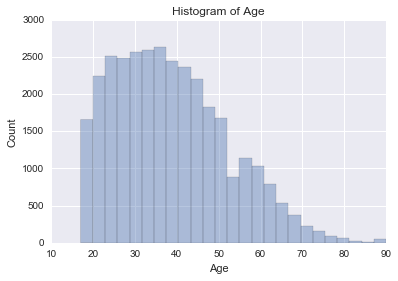

In [30]:
%matplotlib inline
sns.distplot(train_data.age, bins = 25, kde = False)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
#plt.show()

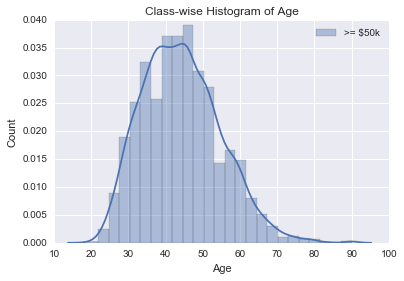

In [31]:
sns.distplot(train_data[train_data['class'] == '1'].age, bins = 25, kde = True, label = ">= $50k")
plt.title('Class-wise Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc="upper right")

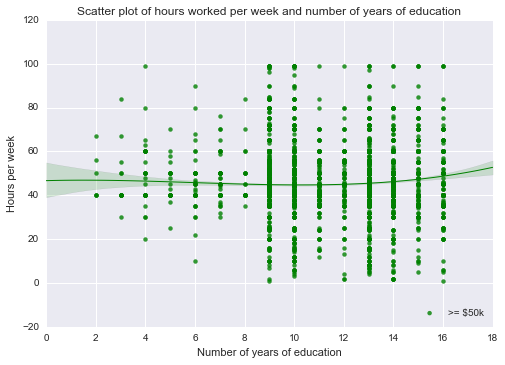

In [32]:
sns.set(color_codes=True)
train_data['education-num'] = train_data['education-num'].map(int)
sns.regplot('education-num', 'hours-per-week', train_data[train_data['class'] == '1'], 
            scatter_kws={"marker": ".", "color": "green"},
            line_kws = {"linewidth": "1", "color": "green"},
            order = 3,
            label = '>= $50k')
plt.xlabel('Number of years of education')
plt.ylabel('Hours per week')
plt.legend(loc="lower right")
plt.title("Scatter plot of hours worked per week and number of years of education")

## Binning numeric values

In [33]:
def binning(col,bin_num):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  

  #if no labels provided, use default labels 0 ... (n-1)
  
  labels = ['BIN_'+str(i) for i in range(bin_num)]

  #Binning using cut function of pandas
  #colBin = pd.cut(col,bin_num,include_lowest=True)
  colBin = pd.cut(col,bin_num,labels=labels,include_lowest=True)
  return colBin

In [34]:
age=train_data['age'].head(5)
age_b=binning(train_data['age'],20).head(5)
for i in enumerate(zip(age,age_b)):
    print(i[1])

(21.0, 'BIN_1')
(59.0, 'BIN_11')
(54.0, 'BIN_10')
(40.0, 'BIN_6')
(25.0, 'BIN_2')


In [35]:
#bin all numeric variables:
categorical_variables = ['workclass', 'education', 'education-num', 'marital-status', 
                         'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_variables = ['hours-per-week','age','capital-gain','capital-loss']


numeric_variables_binned = []
for variable in numeric_variables:
    binned_output_column = variable + "_binned"
    train_data[binned_output_column] = binning(train_data[variable],20)
    test_data[binned_output_column] = binning(test_data[variable],20)
    numeric_variables_binned.append(binned_output_column)

In [36]:
train_data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,hours-per-week_binned,age_binned,capital-gain_binned,capital-loss_binned
27952,21.0,Private,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0.0,0.0,32.0,United-States,0,BIN_6,BIN_1,BIN_0,BIN_0
15390,59.0,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States,1,BIN_7,BIN_11,BIN_0,BIN_0
18886,54.0,Private,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,44.0,United-States,0,BIN_8,BIN_10,BIN_0,BIN_0
11885,40.0,Private,Assoc-acdm,12,Never-married,Adm-clerical,Not-in-family,White,Female,0.0,0.0,40.0,United-States,0,BIN_7,BIN_6,BIN_0,BIN_0
25927,25.0,Private,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0.0,0.0,40.0,United-States,0,BIN_7,BIN_2,BIN_0,BIN_0


## One Hot encoding:

In [37]:
pd.get_dummies(train_data['relationship'],prefix='relationship').head(10)

,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
27952,0.0,0.0,0.0,1.0,0.0,0.0
15390,1.0,0.0,0.0,0.0,0.0,0.0
18886,1.0,0.0,0.0,0.0,0.0,0.0
11885,0.0,1.0,0.0,0.0,0.0,0.0
25927,0.0,1.0,0.0,0.0,0.0,0.0
5431,0.0,0.0,0.0,0.0,0.0,1.0
4963,0.0,1.0,0.0,0.0,0.0,0.0
985,0.0,1.0,0.0,0.0,0.0,0.0
26040,0.0,1.0,0.0,0.0,0.0,0.0
1463,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#Encode all binned numeric columns and categorical columns with oneHot
oh_train = train_data['class']
oh_test = test_data['class']

for variable in numeric_variables_binned+categorical_variables:
    onehot_train_col = pd.get_dummies(train_data[variable],prefix=variable)
    oh_train = pd.concat([oh_train,onehot_train_col],axis=1)
    
    onehot_test_col = pd.get_dummies(test_data[variable],prefix=variable)
    oh_test = pd.concat([oh_test,onehot_test_col],axis=1)

In [61]:
#check for missing values:
missing=[]
for i in oh_train.keys():
    if i not in oh_test.keys():
        missing.append(i)
for i in missing:
    oh_test[i]=0.0

## Build the model: Logistic regression

In [62]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)

#separate labels from data
train_class = oh_train['class']
oh_train_data= oh_train.drop('class',axis=1)

In [63]:
logreg.fit(oh_train_data, train_class)
print(logreg)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


## Evaluate results

In [90]:
from sklearn import metrics

test_class = oh_test['class']


expected = test_class.values
oh_test_data= oh_test.drop('class',axis=1)
predicted = logreg.predict(oh_test_data)
predicted_probs = logreg.predict_proba(oh_test_data)

In [103]:
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.81      0.97      0.89     12435
          1       0.76      0.28      0.41      3846

avg / total       0.80      0.81      0.77     16281

[ 0.00229664  0.23970629  0.08784965 ...,  0.25690392  0.16952656
  0.30020259]


## Cross-validation

In [85]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, oh_test_data, test_class, cv=5)

In [86]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.01)


## Understanding Model Performance

In [68]:
import sklearn.metrics
 
def plotRoc(fpr, tpr, auc):
  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
    
def plotPR(precision, recall):
  plt.figure()
  plt.plot(recall, precision, label='PR curve')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision Recall curve')
  plt.legend(loc='lower left')
  plt.show()
 
def plotMetrics(expected,predicted):
  y_true = expected
  y_score = predicted
  #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
  auc = sklearn.metrics.roc_auc_score(y_true, y_score)
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
  plotRoc(fpr, tpr, auc)
  precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
  plotPR(precision, recall)

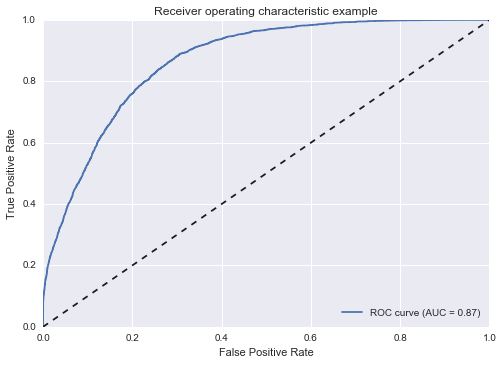

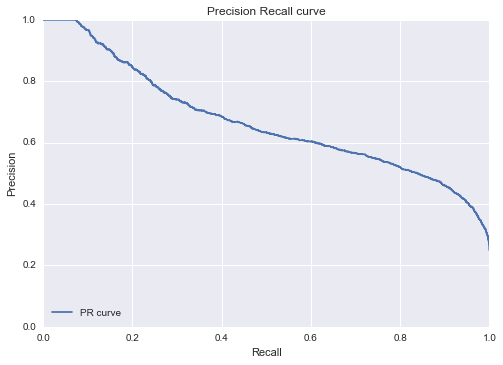

In [104]:
#plotMetrics(expected.astype('int'),predicted.astype('int'))
plotMetrics(expected.astype('int'),predicted_probs[:,1])